<a href="https://colab.research.google.com/github/therealcs1010/CS4248-Project/blob/main/Fatin%5CFatin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Get Data and Preprocess**

In [1]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def preprocess(text):
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    text = text.lower()
    words = text.split()
    words = [w for w in words if not w in set(stopwords.words("english"))]
    words = [WordNetLemmatizer().lemmatize(word) for word in words]
    return " ".join(words)

In [3]:
def get_data(file):
    data = pd.read_json(file)
    x_data = data['text'].apply(preprocess)
    y_data = data['label']
    return x_data, y_data

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
x_train, y_train = get_data('/content/drive/MyDrive/train.json')
x_test, y_test = get_data('/content/drive/MyDrive/test.json')

In [3]:
#x_train.to_csv('/content/drive/MyDrive/x_train.csv')
#x_test.to_csv('/content/drive/MyDrive/x_test.csv')
x_train = pd.read_csv('/content/drive/MyDrive/x_train.csv', index_col=False, header=0)['text']
x_test = pd.read_csv('/content/drive/MyDrive/x_test.csv', index_col=False, header=0)['text']
x_train

0        bromwell high cartoon comedy ran time program ...
1        homelessness houselessness george carlin state...
2        brilliant overacting lesley ann warren best dr...
3        easily underrated film inn brook cannon sure f...
4        typical mel brook film much le slapstick movie...
                               ...                        
24995    towards end movie felt technical felt like cla...
24996    kind movie enemy content watch time bloody tru...
24997    saw descent last night stockholm film festival...
24998    film pick pound turn rather good 23rd century ...
24999    one dumbest film ive ever seen rip nearly ever...
Name: text, Length: 25000, dtype: object

In [4]:
# y_train.to_csv('/content/drive/MyDrive/y_train.csv')
# y_test.to_csv('/content/drive/MyDrive/y_test.csv')
y_train = pd.read_csv('/content/drive/MyDrive/y_train.csv', index_col=False, header=0)['label']
y_test = pd.read_csv('/content/drive/MyDrive/y_test.csv', index_col=False, header=0)['label']
y_train.unique()

array(['+', '-'], dtype=object)

# **Feature Engineering with BoW and Tf-idf**

In [5]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [6]:
def get_bow(clean_train_text, clean_test_text):
    vectorizer = CountVectorizer(analyzer = "word", max_features = 10000) 
    train_bow = vectorizer.fit_transform(clean_train_text).toarray()
    test_bow = vectorizer.transform(clean_test_text).toarray()
    return train_bow, test_bow

In [7]:
def get_tfidf(train_bow, test_bow):
    tfidf_transformer = TfidfTransformer().fit(train_bow)
    train_tfidf = tfidf_transformer.transform(train_bow)
    test_tfidf = tfidf_transformer.transform(test_bow)
    return train_tfidf, test_tfidf

In [8]:
train_bow, test_bow = get_bow(x_train.tolist(), x_test.tolist())
train_tfidf, test_tfidf = get_tfidf(train_bow, test_bow)
train_tfidf

<25000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2189419 stored elements in Compressed Sparse Row format>

In [9]:
mapping = {'+': 1, '-': -1}
train_sentiment = y_train.replace(mapping)
test_sentiment = y_test.replace(mapping)
train_sentiment

0        1
1        1
2        1
3        1
4        1
        ..
24995   -1
24996   -1
24997   -1
24998   -1
24999   -1
Name: label, Length: 25000, dtype: int64

# **Get Metrics and Plots**

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score, f1_score

In [11]:
def get_metrics(y_test, preds):
    accuracy = accuracy_score(y_test, preds)
    print('Accuracy:', accuracy)
    f1 = f1_score(y_test, preds)
    print('F1 Score:', f1)

In [12]:
def get_plot(y_test, preds, title, file):
    fpr, tpr, _ = roc_curve(y_test, preds)
    plt.plot(fpr, tpr)
    plt.title(title)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig('data/' + file + '.png')
    plt.show()

# **Get Results from models (Naive Bayes)**

In [13]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB

Accuracy: 0.65856
F1 Score: 0.5715719734992973


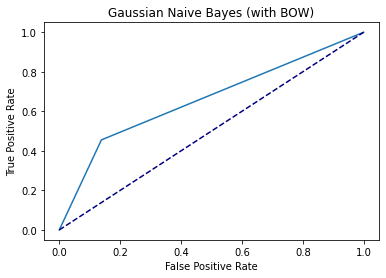

In [14]:
model = GaussianNB()
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Gaussian Naive Bayes (with BOW)', 'gaussian_nb_bow')          

Accuracy: 0.72012
F1 Score: 0.6909588799081312


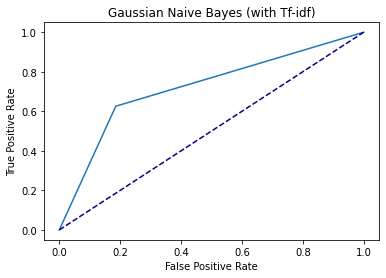

In [15]:
model = GaussianNB()
model.fit(train_tfidf.toarray(), train_sentiment)
preds = model.predict(test_tfidf.toarray())
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Gaussian Naive Bayes (with Tf-idf)', 'gaussian_nb_tfidf')        

Accuracy: 0.834
F1 Score: 0.8271697484591036


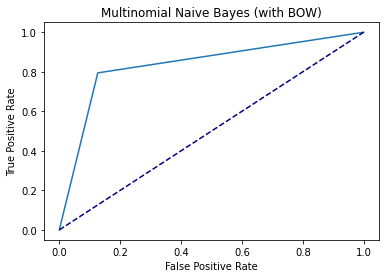

In [16]:
model = MultinomialNB()
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Multinomial Naive Bayes (with BOW)', 'multinomial_nb_bow')

Accuracy: 0.839
F1 Score: 0.8337532526537524


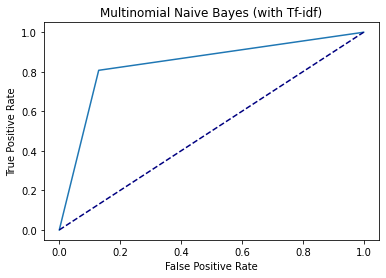

In [17]:
model = MultinomialNB()
model.fit(train_tfidf.toarray(), train_sentiment)
preds = model.predict(test_tfidf.toarray())
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Multinomial Naive Bayes (with Tf-idf)', 'multinomial_nb_tfidf')

Accuracy: 0.834
F1 Score: 0.8271697484591036


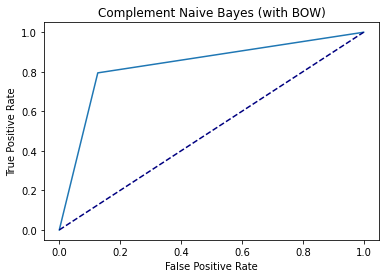

In [18]:
model = ComplementNB()
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Complement Naive Bayes (with BOW)', 'complement_nb_bow')

Accuracy: 0.839
F1 Score: 0.8337532526537524


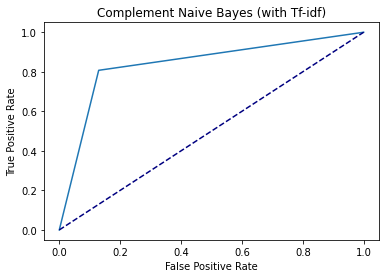

In [19]:
model = ComplementNB()
model.fit(train_tfidf.toarray(), train_sentiment)
preds = model.predict(test_tfidf.toarray())
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Complement Naive Bayes (with Tf-idf)', 'complement_nb_tfidf')        

Accuracy: 0.83832
F1 Score: 0.8322682380280522


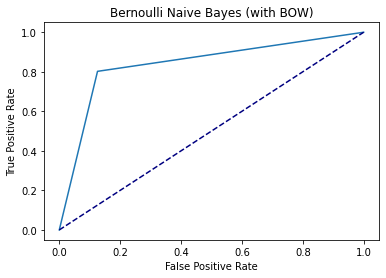

In [20]:
model = BernoulliNB()
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Bernoulli Naive Bayes (with BOW)', 'bernoulli_nb_bow')

Accuracy: 0.83832
F1 Score: 0.8322682380280522


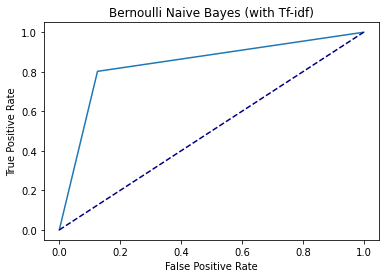

In [21]:
model = BernoulliNB()
model.fit(train_tfidf.toarray(), train_sentiment)
preds = model.predict(test_tfidf.toarray())
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Bernoulli Naive Bayes (with Tf-idf)', 'bernoulli_nb_tfidf')

# **Get Results from models (Decision Trees and Random Forest)**

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Accuracy: 0.7168
F1 Score: 0.7147001934235977


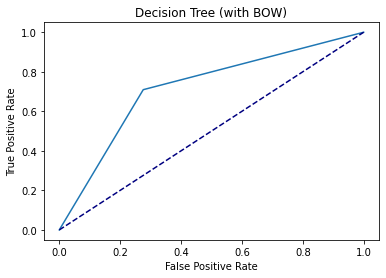

In [23]:
model = DecisionTreeClassifier(random_state=4248)
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Decision Tree (with BOW)', 'decision_tree_bow')

Accuracy: 0.71064
F1 Score: 0.7073861338079442


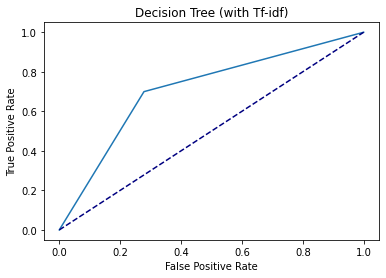

In [24]:
model = DecisionTreeClassifier(random_state=4248)
model.fit(train_tfidf.toarray(), train_sentiment)
preds = model.predict(test_tfidf.toarray())
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Decision Tree (with Tf-idf)', 'decision_tree_tfidf')

Accuracy: 0.84496
F1 Score: 0.8438985098670962


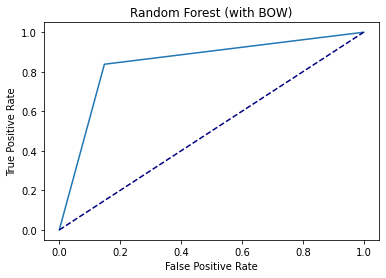

In [25]:
model = RandomForestClassifier(random_state=4248)
model.fit(train_bow, train_sentiment)
preds = model.predict(test_bow)
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Random Forest (with BOW)', 'random_forest_bow')       

Accuracy: 0.8464
F1 Score: 0.8438389589263928


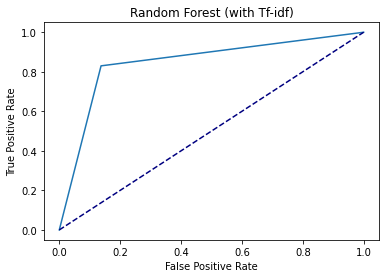

In [26]:
model = RandomForestClassifier(random_state=4248)
model.fit(train_tfidf.toarray(), train_sentiment)
preds = model.predict(test_tfidf.toarray())
get_metrics(test_sentiment, preds)
get_plot(test_sentiment, preds, 'Random Forest (with Tf-idf)', 'random_forest_tfidf')        